In [187]:
import pandas as pd

# Load the dataset
file_path = 'long_format_2.csv'
data = pd.read_csv(file_path)

# Inspect the dataset
print(data.head())
print(data.info())


                  Country Name          2000          2001          2002   
0                        Aruba  21026.167090  20911.192770  21375.269120  \
1  Africa Eastern and Southern    710.665706    631.595695    631.928282   
2                  Afghanistan    498.708320    427.302285    182.174037   
3   Africa Western and Central    519.757395    532.272576    619.712652   
4                       Angola    556.884244    527.464118    872.657638   

           2003          2004          2005          2006          2007   
0  22050.589870  24105.524120  24978.221670  25832.925560  27665.299480  \
1    818.121921    991.192169   1126.375948   1232.423412   1376.638778   
2    199.643228    221.830531    254.115274    274.015394    376.318296   
3    697.851236    841.297352   1000.793722   1243.173889   1421.272934   
4    982.805590   1254.696126   1900.723816   2597.963585   3121.348735   

           2008  ...          2014          2015          2016          2017   
0  29011.639

In [188]:
# Melt the dataframe to have 'Year' as one of the columns
data_melted = data.melt(id_vars=['Country Name', 'Region'], var_name='Year', value_name='GDP')

# Convert 'Year' to numeric
data_melted['Year'] = pd.to_numeric(data_melted['Year'])

# Calculate the mean GDP for each year and region
mean_gdp = data_melted.groupby(['Region', 'Year'])['GDP'].mean().reset_index()

# Pivot the data to have years as index and regions as columns
gdp_pivot = mean_gdp.pivot(index='Year', columns='Region', values='GDP')

# Inspect the pivot table
print(gdp_pivot.head())

gdp_pivot.to_csv('gdp_pivot.csv')

Region  Central and Southern Asia  Eastern and South-Eastern Asia   
Year                                                                
2000                   716.065386                     7963.044220  \
2001                   798.672529                     7431.530928   
2002                   814.652178                     7540.072719   
2003                   953.582589                     8055.614928   
2004                  1126.953781                     9087.666105   

Region  Europe and Northern America  Latin America and Caribbean   
Year                                                               
2000                   18742.675751                  6178.751590  \
2001                   18986.744536                  6376.378238   
2002                   20634.941572                  6503.859555   
2003                   24590.673474                  6818.575760   
2004                   28120.814493                  7634.241777   

Region  Northern Africa and Western Asi

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
04:53:23 - c

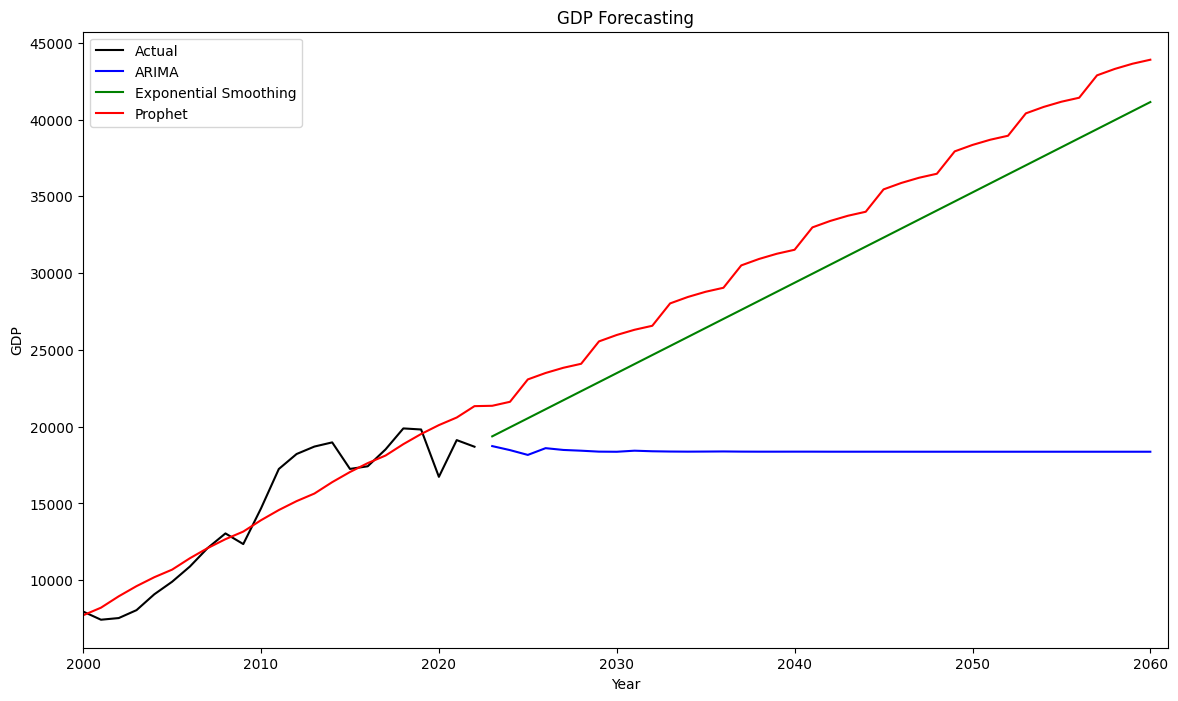

ARIMA RMSE: 2078.4809767146176
Exponential Smoothing RMSE: 1273.0174959215533
Prophet RMSE: 1657.2418641348643


In [189]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from prophet import Prophet
from sklearn.metrics import mean_squared_error

# Load the data
data = pd.read_csv('Eastern and South-Eastern Asia.csv')

df = pd.DataFrame(data)
df['Year'] = pd.to_datetime(df['Year'], format='%Y')
df.set_index('Year', inplace=True)

# ARIMA Model
arima_order = (5, 1, 0)
arima_model = ARIMA(df['GDP'], order=arima_order)
arima_result = arima_model.fit()
arima_forecast = arima_result.get_forecast(steps=38)
arima_forecast_series = arima_forecast.predicted_mean

# Exponential Smoothing Model
es_model = ExponentialSmoothing(df['GDP'], trend='add', seasonal=None)
es_result = es_model.fit()
es_forecast = es_result.forecast(steps=38)

# Prophet Model
df_prophet = df.reset_index().rename(columns={'Year': 'ds', 'GDP': 'y'})
prophet_model = Prophet()
prophet_model.fit(df_prophet)
future = prophet_model.make_future_dataframe(periods=38, freq='Y')
prophet_forecast = prophet_model.predict(future)
prophet_forecast_series = prophet_forecast.set_index('ds')['yhat']

# Plotting the forecasts
plt.figure(figsize=(14, 8))

# Actual Data
plt.plot(df.index, df['GDP'], label='Actual', color='black')

# ARIMA Forecast
arima_forecast_index = pd.date_range(start=df.index[-1] + pd.offsets.YearEnd(), periods=38, freq='Y')
plt.plot(arima_forecast_index, arima_forecast_series, label='ARIMA', color='blue')

# Exponential Smoothing Forecast
es_forecast_index = pd.date_range(start=df.index[-1] + pd.offsets.YearEnd(), periods=38, freq='Y')
plt.plot(es_forecast_index, es_forecast, label='Exponential Smoothing', color='green')

# Prophet Forecast
plt.plot(prophet_forecast_series.index, prophet_forecast_series, label='Prophet', color='red')

plt.xlim(pd.Timestamp('2000-01-01'), pd.Timestamp('2060-12-31'))
plt.title('GDP Forecasting')
plt.xlabel('Year')
plt.ylabel('GDP')
plt.legend()
plt.show()

# RMSE Calculation
arima_rmse = np.sqrt(mean_squared_error(df['GDP'], arima_result.fittedvalues))
es_rmse = np.sqrt(mean_squared_error(df['GDP'], es_result.fittedvalues))
prophet_rmse = np.sqrt(mean_squared_error(df['GDP'], prophet_model.predict(df_prophet)['yhat']))

print(f'ARIMA RMSE: {arima_rmse}')
print(f'Exponential Smoothing RMSE: {es_rmse}')
print(f'Prophet RMSE: {prophet_rmse}')


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
04:53:24 - c

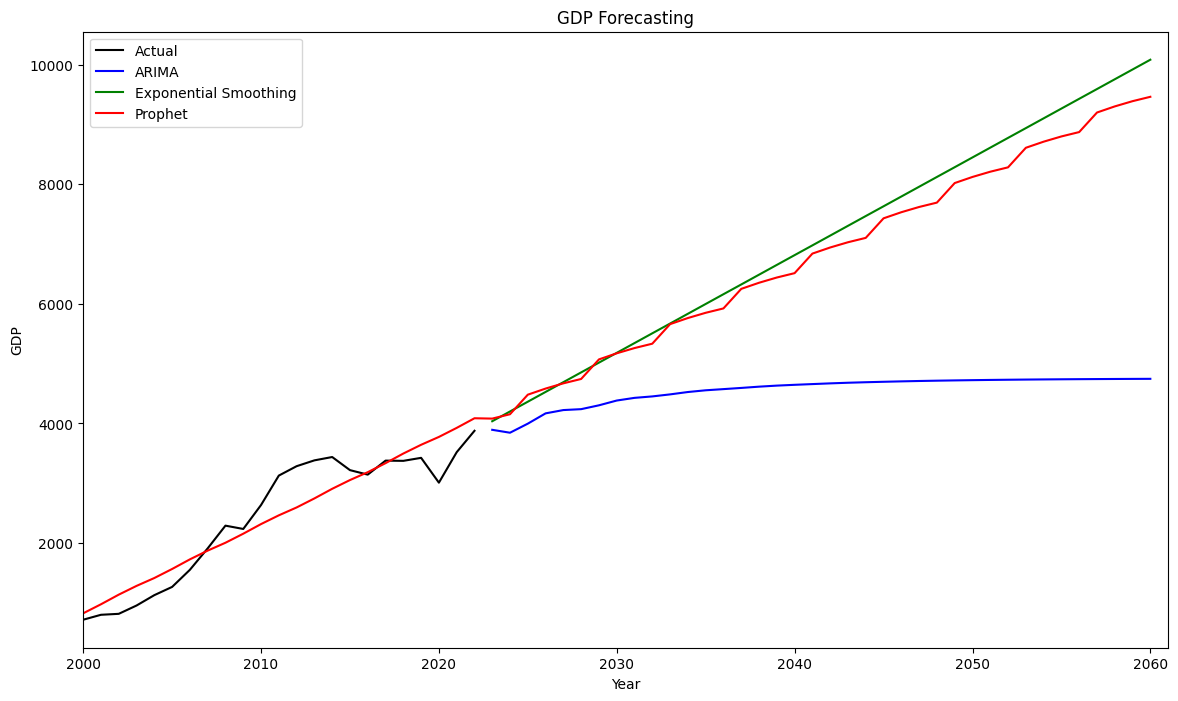

ARIMA RMSE: 270.1181184779958
Exponential Smoothing RMSE: 225.89565368523395
Prophet RMSE: 369.6145288722074


In [190]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from prophet import Prophet
from sklearn.metrics import mean_squared_error

# Load the data
data = pd.read_csv('Central and Southern Asia.csv')

df = pd.DataFrame(data)
df['Year'] = pd.to_datetime(df['Year'], format='%Y')
df.set_index('Year', inplace=True)

# ARIMA Model
arima_order = (5, 1, 0)
arima_model = ARIMA(df['GDP'], order=arima_order)
arima_result = arima_model.fit()
arima_forecast = arima_result.get_forecast(steps=38)
arima_forecast_series = arima_forecast.predicted_mean

# Exponential Smoothing Model
es_model = ExponentialSmoothing(df['GDP'], trend='add', seasonal=None)
es_result = es_model.fit()
es_forecast = es_result.forecast(steps=38)

# Prophet Model
df_prophet = df.reset_index().rename(columns={'Year': 'ds', 'GDP': 'y'})
prophet_model = Prophet()
prophet_model.fit(df_prophet)
future = prophet_model.make_future_dataframe(periods=38, freq='Y')
prophet_forecast = prophet_model.predict(future)
prophet_forecast_series = prophet_forecast.set_index('ds')['yhat']

# Plotting the forecasts
plt.figure(figsize=(14, 8))

# Actual Data
plt.plot(df.index, df['GDP'], label='Actual', color='black')

# ARIMA Forecast
arima_forecast_index = pd.date_range(start=df.index[-1] + pd.offsets.YearEnd(), periods=38, freq='Y')
plt.plot(arima_forecast_index, arima_forecast_series, label='ARIMA', color='blue')

# Exponential Smoothing Forecast
es_forecast_index = pd.date_range(start=df.index[-1] + pd.offsets.YearEnd(), periods=38, freq='Y')
plt.plot(es_forecast_index, es_forecast, label='Exponential Smoothing', color='green')

# Prophet Forecast
plt.plot(prophet_forecast_series.index, prophet_forecast_series, label='Prophet', color='red')

plt.xlim(pd.Timestamp('2000-01-01'), pd.Timestamp('2060-12-31'))
plt.title('GDP Forecasting')
plt.xlabel('Year')
plt.ylabel('GDP')
plt.legend()
plt.show()

# RMSE Calculation
arima_rmse = np.sqrt(mean_squared_error(df['GDP'], arima_result.fittedvalues))
es_rmse = np.sqrt(mean_squared_error(df['GDP'], es_result.fittedvalues))
prophet_rmse = np.sqrt(mean_squared_error(df['GDP'], prophet_model.predict(df_prophet)['yhat']))

print(f'ARIMA RMSE: {arima_rmse}')
print(f'Exponential Smoothing RMSE: {es_rmse}')
print(f'Prophet RMSE: {prophet_rmse}')


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
04:53:24 - c

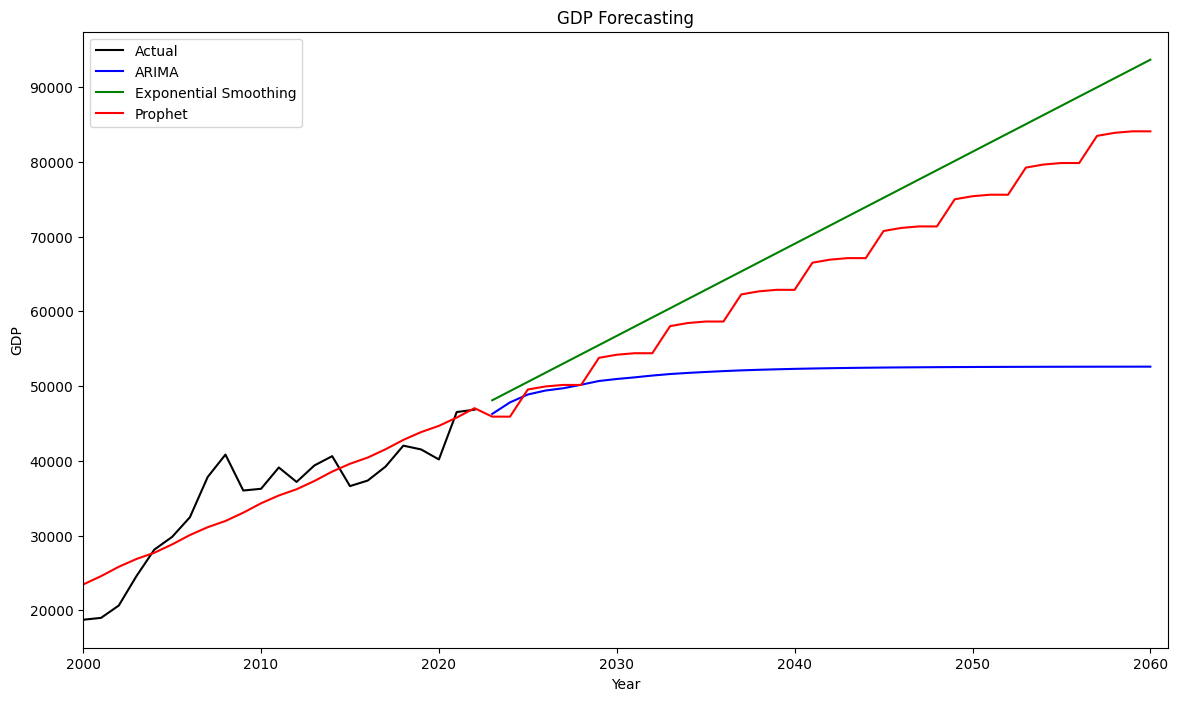

ARIMA RMSE: 4570.517674775181
Exponential Smoothing RMSE: 2743.861140178511
Prophet RMSE: 3628.32711226127


In [191]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from prophet import Prophet
from sklearn.metrics import mean_squared_error

# Load the data
data = pd.read_csv('Europe and Northern America.csv')

df = pd.DataFrame(data)
df['Year'] = pd.to_datetime(df['Year'], format='%Y')
df.set_index('Year', inplace=True)

# ARIMA Model
arima_order = (5, 1, 0)
arima_model = ARIMA(df['GDP'], order=arima_order)
arima_result = arima_model.fit()
arima_forecast = arima_result.get_forecast(steps=38)
arima_forecast_series = arima_forecast.predicted_mean

# Exponential Smoothing Model
es_model = ExponentialSmoothing(df['GDP'], trend='add', seasonal=None)
es_result = es_model.fit()
es_forecast = es_result.forecast(steps=38)

# Prophet Model
df_prophet = df.reset_index().rename(columns={'Year': 'ds', 'GDP': 'y'})
prophet_model = Prophet()
prophet_model.fit(df_prophet)
future = prophet_model.make_future_dataframe(periods=38, freq='Y')
prophet_forecast = prophet_model.predict(future)
prophet_forecast_series = prophet_forecast.set_index('ds')['yhat']

# Plotting the forecasts
plt.figure(figsize=(14, 8))

# Actual Data
plt.plot(df.index, df['GDP'], label='Actual', color='black')

# ARIMA Forecast
arima_forecast_index = pd.date_range(start=df.index[-1] + pd.offsets.YearEnd(), periods=38, freq='Y')
plt.plot(arima_forecast_index, arima_forecast_series, label='ARIMA', color='blue')

# Exponential Smoothing Forecast
es_forecast_index = pd.date_range(start=df.index[-1] + pd.offsets.YearEnd(), periods=38, freq='Y')
plt.plot(es_forecast_index, es_forecast, label='Exponential Smoothing', color='green')

# Prophet Forecast
plt.plot(prophet_forecast_series.index, prophet_forecast_series, label='Prophet', color='red')

plt.xlim(pd.Timestamp('2000-01-01'), pd.Timestamp('2060-12-31'))
plt.title('GDP Forecasting')
plt.xlabel('Year')
plt.ylabel('GDP')
plt.legend()
plt.show()

# RMSE Calculation
arima_rmse = np.sqrt(mean_squared_error(df['GDP'], arima_result.fittedvalues))
es_rmse = np.sqrt(mean_squared_error(df['GDP'], es_result.fittedvalues))
prophet_rmse = np.sqrt(mean_squared_error(df['GDP'], prophet_model.predict(df_prophet)['yhat']))

print(f'ARIMA RMSE: {arima_rmse}')
print(f'Exponential Smoothing RMSE: {es_rmse}')
print(f'Prophet RMSE: {prophet_rmse}')


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
04:53:25 - c

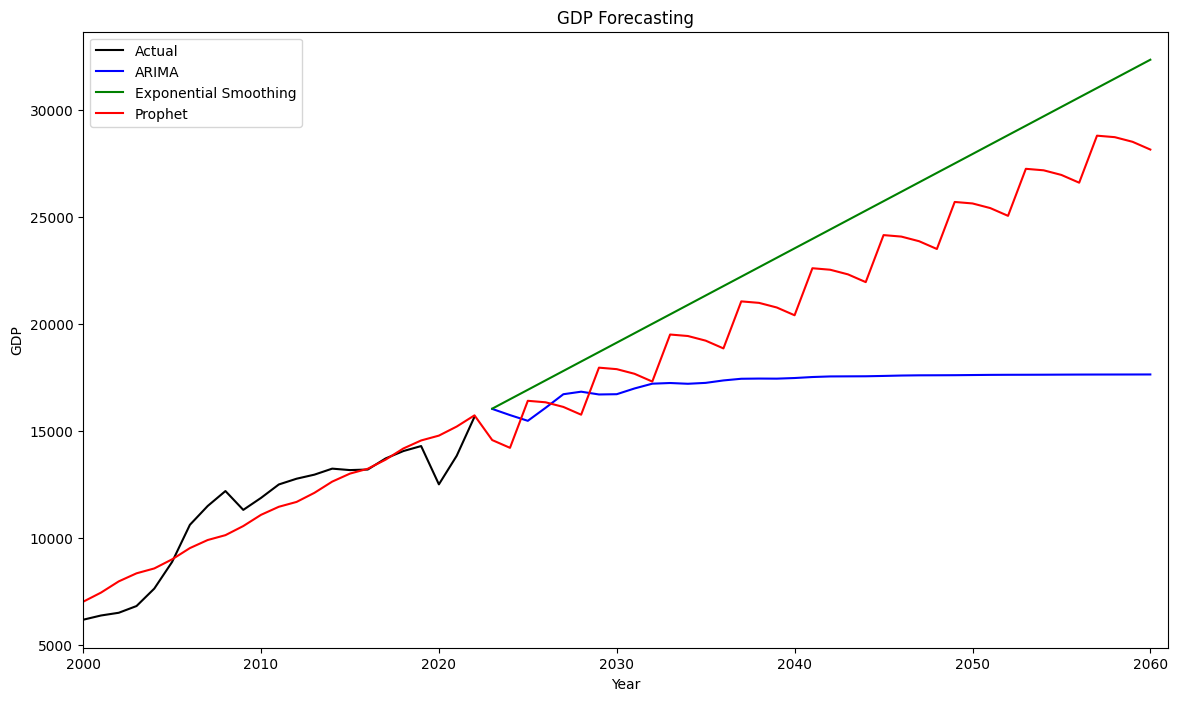

ARIMA RMSE: 1492.3307905230142
Exponential Smoothing RMSE: 812.6146421591731
Prophet RMSE: 1082.0383552949977


In [192]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from prophet import Prophet
from sklearn.metrics import mean_squared_error

# Load the data
data = pd.read_csv('Latin America and Caribbean.csv')

df = pd.DataFrame(data)
df['Year'] = pd.to_datetime(df['Year'], format='%Y')
df.set_index('Year', inplace=True)

# ARIMA Model
arima_order = (5, 1, 0)
arima_model = ARIMA(df['GDP'], order=arima_order)
arima_result = arima_model.fit()
arima_forecast = arima_result.get_forecast(steps=38)
arima_forecast_series = arima_forecast.predicted_mean

# Exponential Smoothing Model
es_model = ExponentialSmoothing(df['GDP'], trend='add', seasonal=None)
es_result = es_model.fit()
es_forecast = es_result.forecast(steps=38)

# Prophet Model
df_prophet = df.reset_index().rename(columns={'Year': 'ds', 'GDP': 'y'})
prophet_model = Prophet()
prophet_model.fit(df_prophet)
future = prophet_model.make_future_dataframe(periods=38, freq='Y')
prophet_forecast = prophet_model.predict(future)
prophet_forecast_series = prophet_forecast.set_index('ds')['yhat']

# Plotting the forecasts
plt.figure(figsize=(14, 8))

# Actual Data
plt.plot(df.index, df['GDP'], label='Actual', color='black')

# ARIMA Forecast
arima_forecast_index = pd.date_range(start=df.index[-1] + pd.offsets.YearEnd(), periods=38, freq='Y')
plt.plot(arima_forecast_index, arima_forecast_series, label='ARIMA', color='blue')

# Exponential Smoothing Forecast
es_forecast_index = pd.date_range(start=df.index[-1] + pd.offsets.YearEnd(), periods=38, freq='Y')
plt.plot(es_forecast_index, es_forecast, label='Exponential Smoothing', color='green')

# Prophet Forecast
plt.plot(prophet_forecast_series.index, prophet_forecast_series, label='Prophet', color='red')

plt.xlim(pd.Timestamp('2000-01-01'), pd.Timestamp('2060-12-31'))
plt.title('GDP Forecasting')
plt.xlabel('Year')
plt.ylabel('GDP')
plt.legend()
plt.show()

# RMSE Calculation
arima_rmse = np.sqrt(mean_squared_error(df['GDP'], arima_result.fittedvalues))
es_rmse = np.sqrt(mean_squared_error(df['GDP'], es_result.fittedvalues))
prophet_rmse = np.sqrt(mean_squared_error(df['GDP'], prophet_model.predict(df_prophet)['yhat']))

print(f'ARIMA RMSE: {arima_rmse}')
print(f'Exponential Smoothing RMSE: {es_rmse}')
print(f'Prophet RMSE: {prophet_rmse}')


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
04:53:25 - c

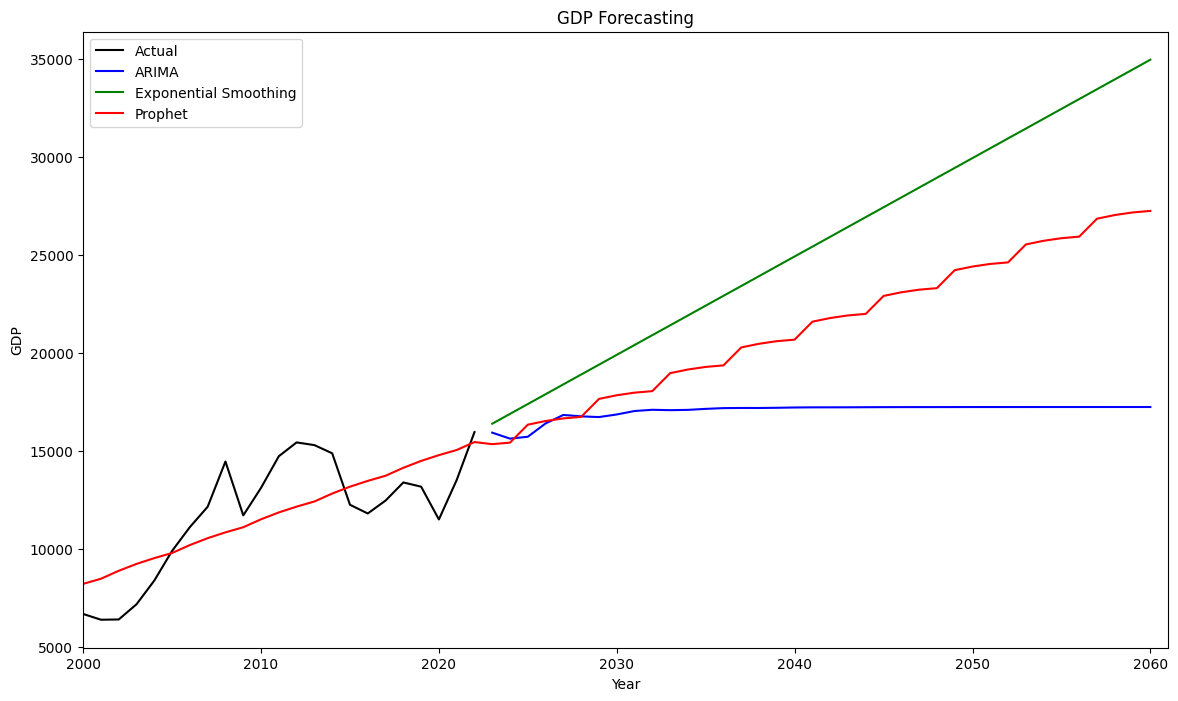

ARIMA RMSE: 1937.219584738981
Exponential Smoothing RMSE: 1413.7222931376002
Prophet RMSE: 1982.9567337598492


In [193]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from prophet import Prophet
from sklearn.metrics import mean_squared_error

# Load the data
data = pd.read_csv('Northern Africa and Western Asia.csv')

df = pd.DataFrame(data)
df['Year'] = pd.to_datetime(df['Year'], format='%Y')
df.set_index('Year', inplace=True)

# ARIMA Model
arima_order = (5, 1, 0)
arima_model = ARIMA(df['GDP'], order=arima_order)
arima_result = arima_model.fit()
arima_forecast = arima_result.get_forecast(steps=38)
arima_forecast_series = arima_forecast.predicted_mean

# Exponential Smoothing Model
es_model = ExponentialSmoothing(df['GDP'], trend='add', seasonal=None)
es_result = es_model.fit()
es_forecast = es_result.forecast(steps=38)

# Prophet Model
df_prophet = df.reset_index().rename(columns={'Year': 'ds', 'GDP': 'y'})
prophet_model = Prophet()
prophet_model.fit(df_prophet)
future = prophet_model.make_future_dataframe(periods=38, freq='Y')
prophet_forecast = prophet_model.predict(future)
prophet_forecast_series = prophet_forecast.set_index('ds')['yhat']

# Plotting the forecasts
plt.figure(figsize=(14, 8))

# Actual Data
plt.plot(df.index, df['GDP'], label='Actual', color='black')

# ARIMA Forecast
arima_forecast_index = pd.date_range(start=df.index[-1] + pd.offsets.YearEnd(), periods=38, freq='Y')
plt.plot(arima_forecast_index, arima_forecast_series, label='ARIMA', color='blue')

# Exponential Smoothing Forecast
es_forecast_index = pd.date_range(start=df.index[-1] + pd.offsets.YearEnd(), periods=38, freq='Y')
plt.plot(es_forecast_index, es_forecast, label='Exponential Smoothing', color='green')

# Prophet Forecast
plt.plot(prophet_forecast_series.index, prophet_forecast_series, label='Prophet', color='red')

plt.xlim(pd.Timestamp('2000-01-01'), pd.Timestamp('2060-12-31'))
plt.title('GDP Forecasting')
plt.xlabel('Year')
plt.ylabel('GDP')
plt.legend()
plt.show()

# RMSE Calculation
arima_rmse = np.sqrt(mean_squared_error(df['GDP'], arima_result.fittedvalues))
es_rmse = np.sqrt(mean_squared_error(df['GDP'], es_result.fittedvalues))
prophet_rmse = np.sqrt(mean_squared_error(df['GDP'], prophet_model.predict(df_prophet)['yhat']))

print(f'ARIMA RMSE: {arima_rmse}')
print(f'Exponential Smoothing RMSE: {es_rmse}')
print(f'Prophet RMSE: {prophet_rmse}')


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
04:53:26 - c

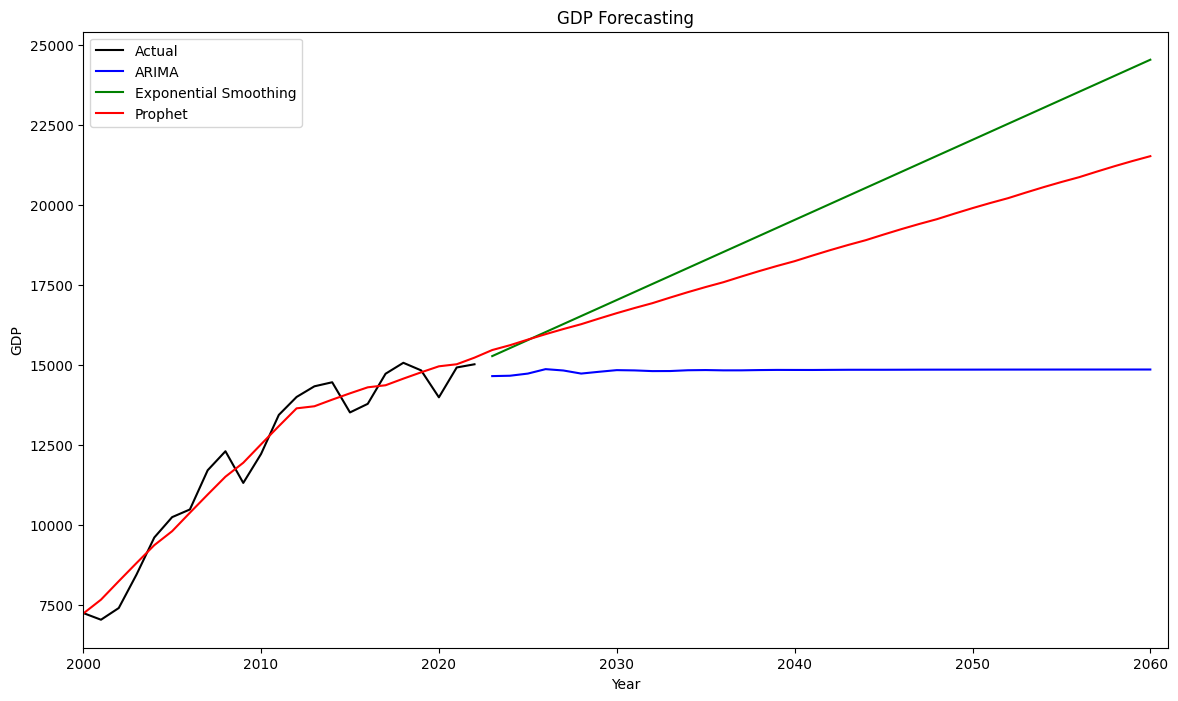

ARIMA RMSE: 1626.3940716995241
Exponential Smoothing RMSE: 680.3660415110761
Prophet RMSE: 515.5471829486335


In [194]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from prophet import Prophet
from sklearn.metrics import mean_squared_error

# Load the data
data = pd.read_csv('Oceania.csv')

df = pd.DataFrame(data)
df['Year'] = pd.to_datetime(df['Year'], format='%Y')
df.set_index('Year', inplace=True)

# ARIMA Model
arima_order = (5, 1, 0)
arima_model = ARIMA(df['GDP'], order=arima_order)
arima_result = arima_model.fit()
arima_forecast = arima_result.get_forecast(steps=38)
arima_forecast_series = arima_forecast.predicted_mean

# Exponential Smoothing Model
es_model = ExponentialSmoothing(df['GDP'], trend='add', seasonal=None)
es_result = es_model.fit()
es_forecast = es_result.forecast(steps=38)

# Prophet Model
df_prophet = df.reset_index().rename(columns={'Year': 'ds', 'GDP': 'y'})
prophet_model = Prophet()
prophet_model.fit(df_prophet)
future = prophet_model.make_future_dataframe(periods=38, freq='Y')
prophet_forecast = prophet_model.predict(future)
prophet_forecast_series = prophet_forecast.set_index('ds')['yhat']

# Plotting the forecasts
plt.figure(figsize=(14, 8))

# Actual Data
plt.plot(df.index, df['GDP'], label='Actual', color='black')

# ARIMA Forecast
arima_forecast_index = pd.date_range(start=df.index[-1] + pd.offsets.YearEnd(), periods=38, freq='Y')
plt.plot(arima_forecast_index, arima_forecast_series, label='ARIMA', color='blue')

# Exponential Smoothing Forecast
es_forecast_index = pd.date_range(start=df.index[-1] + pd.offsets.YearEnd(), periods=38, freq='Y')
plt.plot(es_forecast_index, es_forecast, label='Exponential Smoothing', color='green')

# Prophet Forecast
plt.plot(prophet_forecast_series.index, prophet_forecast_series, label='Prophet', color='red')

plt.xlim(pd.Timestamp('2000-01-01'), pd.Timestamp('2060-12-31'))
plt.title('GDP Forecasting')
plt.xlabel('Year')
plt.ylabel('GDP')
plt.legend()
plt.show()

# RMSE Calculation
arima_rmse = np.sqrt(mean_squared_error(df['GDP'], arima_result.fittedvalues))
es_rmse = np.sqrt(mean_squared_error(df['GDP'], es_result.fittedvalues))
prophet_rmse = np.sqrt(mean_squared_error(df['GDP'], prophet_model.predict(df_prophet)['yhat']))

print(f'ARIMA RMSE: {arima_rmse}')
print(f'Exponential Smoothing RMSE: {es_rmse}')
print(f'Prophet RMSE: {prophet_rmse}')


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
04:53:27 - c

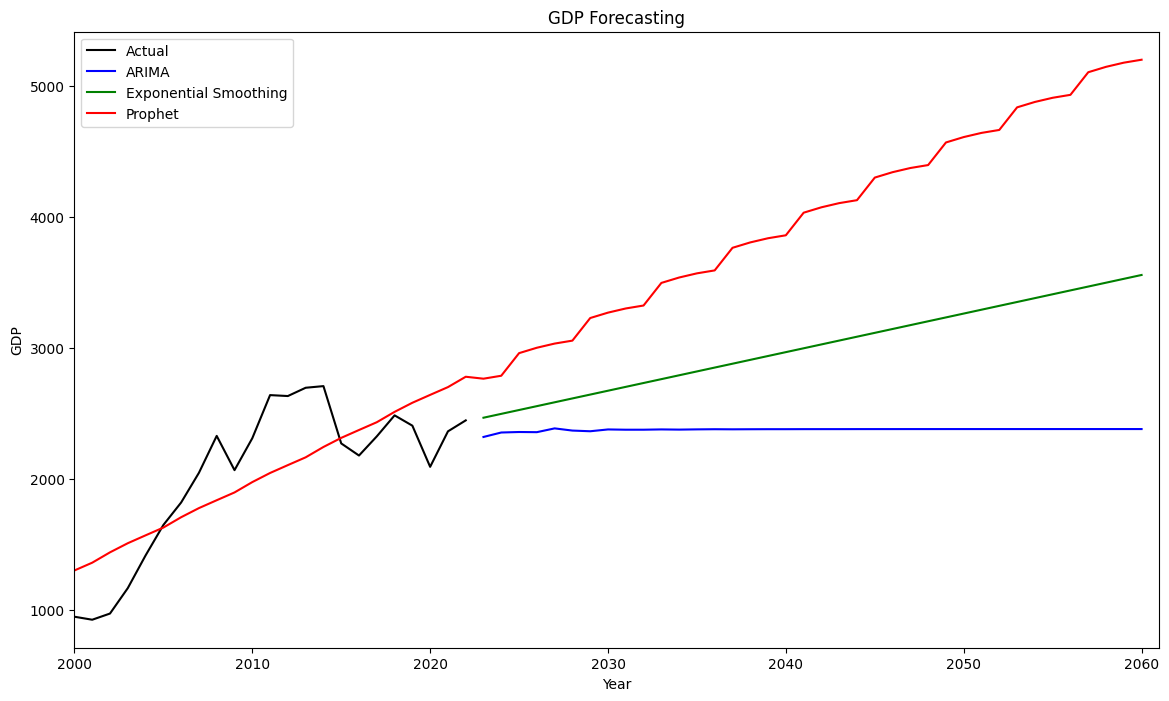

ARIMA RMSE: 273.1219345138503
Exponential Smoothing RMSE: 204.9853452646611
Prophet RMSE: 353.5444587337781


In [195]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from prophet import Prophet
from sklearn.metrics import mean_squared_error

# Load the data
data = pd.read_csv('Sub-Saharan Africa.csv')

df = pd.DataFrame(data)
df['Year'] = pd.to_datetime(df['Year'], format='%Y')
df.set_index('Year', inplace=True)

# ARIMA Model
arima_order = (5, 1, 0)
arima_model = ARIMA(df['GDP'], order=arima_order)
arima_result = arima_model.fit()
arima_forecast = arima_result.get_forecast(steps=38)
arima_forecast_series = arima_forecast.predicted_mean

# Exponential Smoothing Model
es_model = ExponentialSmoothing(df['GDP'], trend='add', seasonal=None)
es_result = es_model.fit()
es_forecast = es_result.forecast(steps=38)

# Prophet Model
df_prophet = df.reset_index().rename(columns={'Year': 'ds', 'GDP': 'y'})
prophet_model = Prophet()
prophet_model.fit(df_prophet)
future = prophet_model.make_future_dataframe(periods=38, freq='Y')
prophet_forecast = prophet_model.predict(future)
prophet_forecast_series = prophet_forecast.set_index('ds')['yhat']

# Plotting the forecasts
plt.figure(figsize=(14, 8))

# Actual Data
plt.plot(df.index, df['GDP'], label='Actual', color='black')

# ARIMA Forecast
arima_forecast_index = pd.date_range(start=df.index[-1] + pd.offsets.YearEnd(), periods=38, freq='Y')
plt.plot(arima_forecast_index, arima_forecast_series, label='ARIMA', color='blue')

# Exponential Smoothing Forecast
es_forecast_index = pd.date_range(start=df.index[-1] + pd.offsets.YearEnd(), periods=38, freq='Y')
plt.plot(es_forecast_index, es_forecast, label='Exponential Smoothing', color='green')

# Prophet Forecast
plt.plot(prophet_forecast_series.index, prophet_forecast_series, label='Prophet', color='red')

plt.xlim(pd.Timestamp('2000-01-01'), pd.Timestamp('2060-12-31'))
plt.title('GDP Forecasting')
plt.xlabel('Year')
plt.ylabel('GDP')
plt.legend()
plt.show()

# RMSE Calculation
arima_rmse = np.sqrt(mean_squared_error(df['GDP'], arima_result.fittedvalues))
es_rmse = np.sqrt(mean_squared_error(df['GDP'], es_result.fittedvalues))
prophet_rmse = np.sqrt(mean_squared_error(df['GDP'], prophet_model.predict(df_prophet)['yhat']))

print(f'ARIMA RMSE: {arima_rmse}')
print(f'Exponential Smoothing RMSE: {es_rmse}')
print(f'Prophet RMSE: {prophet_rmse}')


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
04:53:27 - c

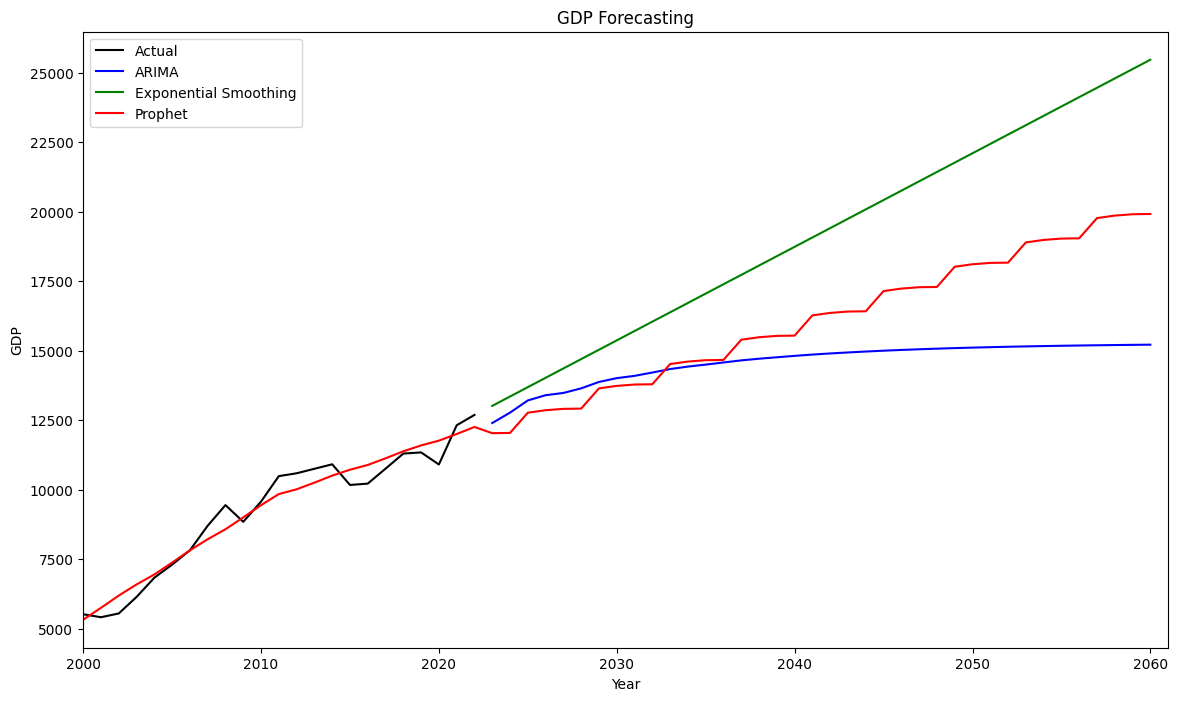

ARIMA RMSE: 1245.8900120703074
Exponential Smoothing RMSE: 520.1479371417572
Prophet RMSE: 464.6748999824404


In [196]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from prophet import Prophet
from sklearn.metrics import mean_squared_error

# Load the data
data = pd.read_csv('World.csv')

df = pd.DataFrame(data)
df['Year'] = pd.to_datetime(df['Year'], format='%Y')
df.set_index('Year', inplace=True)

# ARIMA Model
arima_order = (5, 1, 0)
arima_model = ARIMA(df['GDP'], order=arima_order)
arima_result = arima_model.fit()
arima_forecast = arima_result.get_forecast(steps=38)
arima_forecast_series = arima_forecast.predicted_mean

# Exponential Smoothing Model
es_model = ExponentialSmoothing(df['GDP'], trend='add', seasonal=None)
es_result = es_model.fit()
es_forecast = es_result.forecast(steps=38)

# Prophet Model
df_prophet = df.reset_index().rename(columns={'Year': 'ds', 'GDP': 'y'})
prophet_model = Prophet()
prophet_model.fit(df_prophet)
future = prophet_model.make_future_dataframe(periods=38, freq='Y')
prophet_forecast = prophet_model.predict(future)
prophet_forecast_series = prophet_forecast.set_index('ds')['yhat']

# Plotting the forecasts
plt.figure(figsize=(14, 8))

# Actual Data
plt.plot(df.index, df['GDP'], label='Actual', color='black')

# ARIMA Forecast
arima_forecast_index = pd.date_range(start=df.index[-1] + pd.offsets.YearEnd(), periods=38, freq='Y')
plt.plot(arima_forecast_index, arima_forecast_series, label='ARIMA', color='blue')

# Exponential Smoothing Forecast
es_forecast_index = pd.date_range(start=df.index[-1] + pd.offsets.YearEnd(), periods=38, freq='Y')
plt.plot(es_forecast_index, es_forecast, label='Exponential Smoothing', color='green')

# Prophet Forecast
plt.plot(prophet_forecast_series.index, prophet_forecast_series, label='Prophet', color='red')

plt.xlim(pd.Timestamp('2000-01-01'), pd.Timestamp('2060-12-31'))
plt.title('GDP Forecasting')
plt.xlabel('Year')
plt.ylabel('GDP')
plt.legend()
plt.show()

# RMSE Calculation
arima_rmse = np.sqrt(mean_squared_error(df['GDP'], arima_result.fittedvalues))
es_rmse = np.sqrt(mean_squared_error(df['GDP'], es_result.fittedvalues))
prophet_rmse = np.sqrt(mean_squared_error(df['GDP'], prophet_model.predict(df_prophet)['yhat']))

print(f'ARIMA RMSE: {arima_rmse}')
print(f'Exponential Smoothing RMSE: {es_rmse}')
print(f'Prophet RMSE: {prophet_rmse}')
